In [1]:
import math
from tqdm import tqdm
import numpy as np
from numba import jit, njit
import matplotlib.pyplot as plt
from collections import namedtuple

In [2]:
LRBound = namedtuple('LRBound', ['left', 'right'])
Event = namedtuple('Event', ['x', 'y', 'ts', 'polarity'])
TrainingSample = namedtuple('TrainingSample', ['features', 'label'])

event_dtype = np.dtype([('x', np.uint16), ('y', np.uint16), ('ts', np.float64), ('polarity', np.int8)])

In [3]:
import h5py

filename = './datasets/20samples_N-MNIST.hdf5'
dataset = h5py.File(filename, 'r')

data = dataset['0']['digit_06327']

events = [Event(*ev) for ev in data]
positive_events = [ev for ev in events if ev.polarity == 1]
negative_events = [ev for ev in events if ev.polarity == -1]

In [ ]:
# get the events in recarray format
events_np = np.array(events, dtype=event_dtype)

In [ ]:
%%timeit
events_np = np.array(events, dtype=event_dtype)

## HATS code

In [4]:
def filter_memory(memory, event_ts, temp_window):
    """
        finds all events between [event.ts-temp_window, event.ts)
    """
    limit_ts = event_ts - temp_window
    # Due to the way it is built we only have to find the first extreme
    
    # Find it using binary search
    found = False
    bound = LRBound(0, len(memory) - 1)
    
    while bound.left<=bound.right and not found:
        pos = 0
        midpoint = (bound.left + bound.right)//2
        if memory[midpoint]['ts'] == limit_ts:
            pos = midpoint
            found = True
        else:
            if limit_ts < memory[midpoint]['ts']:
                bound = LRBound(bound.left, midpoint-1)
            else:
                bound = LRBound(midpoint+1, bound.right)
                
    # Return all events starting from that index
    return memory[pos:]

In [5]:
@njit
def get_pixel_cell_partition_matrix(width, height, K):
    """
        The function takes as input the width and the height of the image
        sensor, and the number  K  which is the size of the  C  cells which
        divide the pixel grid. In order to peform quick lookup of which is 
        the corresponding cell for each pixel, this function returns a matrix 
        containing the index of the corresponding cell for each pixel which
        makes the lookup O(1). The indexes are returned in a row manner, i.e:
        
        0 1 2 3 4
        5 6 7 8 9
    
    """
    assert (width % K == 0) and (height % K == 0)
    cell_width = (width // K)
    cell_height = (height // K)
    matrix = np.zeros(shape=(width, height), dtype=np.int32)
    
    for i in range(width):
        for j in range(height):
            pixel_row = i // K
            pixel_col = j // K
            matrix[i,j] = pixel_row*cell_width + pixel_col
    
    return matrix

In [6]:
@njit
def normalise(histograms, event_counter):
    """
        A characteristic of event-based sensors is that the amount
        of events generated by a moving object is proportional to its
        contrast: higher contrast objects generate more events than
        low contrast objects. To make the cell descriptor more invariant 
        to contrast, we therefore normalize h by the number of events |C| 
        contained in the spatio-temporal window used to compute it. 

    """
    result = np.zeros_like(histograms)
        
    # normalise
    for i in range(histograms.shape[0]):
        for p in range(histograms.shape[1]):
            result[i,p] = histograms[i,p]/(event_counter[i,p]+0.1)

    return result

In [7]:
def compute_local_memory_time_surface(event_i, filtered_memory, R, tau):
    """
        The function takes the a filtered memory containing only 
        events in the neighborhood of the event and belonging to the
        temporal window that needs to be considered and outputs a time 
        surface.
    
    """
    # initialize blank time surface
    time_surface = np.zeros(shape=(2*R+1, 2*R+1), dtype=np.float32)
    
    # get the timestamp of the triggering event
    t_i = event_i['ts']
    
    # for every event in the local memory relevant to the event
    # (relevean both in spatial and temporal terms), do:
    for event_j in filtered_memory:
        
        # compute the time delta
        delta_t = t_i - event_j['ts']
        
        # compute contribution to time surface
        event_value = math.exp(-delta_t/tau)
        
        # compute coordinates in the shifted representation
        shifted_y = event_j['y'] - (event_i['y'] - R)
        shifted_x = event_j['x'] - (event_i['x'] - R)
        
        # sum it to the time surface
        time_surface[shifted_y, shifted_x] += event_value
        
    # return the computed time surface
    return time_surface
        

In [8]:
class HATS:
    """
        Parameters:
                    temp_window: temporal window for events
                    tau        : exponential decay constant
                    R          : neighborhood size
                    K          : cell size
                    width      : pixel sensor width
                    height     : pixel sensor height
                    
    """
    def __init__(self, temp_window=0.1, width=35, height=35, delta_t=0.1, tau=0.5, R=7, K=7):
        
        self.temp_window = temp_window
        self.tau = tau
        self.R = R
        self.K = K
        self.index = {-1: 0, 1: 1}
        
        self.cell_width = (width // K)
        self.cell_height = (height // K)
        self.n_cells = self.cell_width * self.cell_height 
        self.n_polarities = 2
        
        self.get_cell = get_pixel_cell_partition_matrix(width, height, K)
        
        self.reset()
        
    def reset(self):
        
        self.histograms = np.zeros(shape=(self.n_cells, self.n_polarities, 2*self.R+1, 2*self.R+1), dtype=np.float32)
        self.event_counter = np.zeros(shape=(self.n_cells, self.n_polarities), dtype=np.uint32)
        self.cell_memory = np.empty([self.n_cells, self.n_polarities], dtype=object)
        
    def process(self, event):
        # Get the cell corresponding to the event
        cell = self.get_cell[event['y'], event['x']]
        polarity_index = self.index[event['polarity']]
        
        # If cell_memory is empty, initialize a list with the event, else add it
        if self.cell_memory[cell, polarity_index] is None: 
            self.cell_memory[cell, polarity_index] = [event]
        else:
            self.cell_memory[cell, polarity_index].append(event)
        
        # Filter Local Memory to only events in Temporal Window
        self.cell_memory[cell, polarity_index] = filter_memory(self.cell_memory[cell, polarity_index], event['ts'], self.temp_window)
        
        # Get the Local Memory Time Surface
        time_surface = compute_local_memory_time_surface(event, self.cell_memory[cell, polarity_index], self.R, self.tau)
        
        # Add the time surface to the cell histograms
        self.histograms[cell, polarity_index, :, :] += time_surface
        
        # Increase the event counter for the cell
        self.event_counter[cell, polarity_index] += 1
        
    def process_all(self, events):
        
        for ev_i in events:
            self.process(ev_i)
            
        self.histograms = normalise(self.histograms, self.event_counter)        

In [9]:
import h5py

fileName = '/mnt/c/Users/Linus/Documents/NMNIST/TrainF/0/0.txt'
with open(fileName, 'r') as f:
        lines = f.readlines()

# line = lines[0].split()
# t = (int(line[0]), int(line[1]), float(line[2])/1000000, int(line[3]))
result = list(map(lambda line: (int(line.split()[0]), int(line.split()[1]), float(line.split()[2])/1000000, 1 if int(line.split()[3]) == 1 else -1), lines))

filename = './datasets/20samples_N-MNIST.hdf5'
dataset = h5py.File(filename, 'r')

data = dataset['0']['digit_06327']

events = [Event(*ev) for ev in result]
positive_events = [ev for ev in events if ev.polarity == 1]
negative_events = [ev for ev in events if ev.polarity == -1]

In [ ]:
# get the events in recarray format
events_np = np.array(events, dtype=event_dtype)

In [ ]:
event_i = events_np[10]

In [ ]:
m = get_pixel_cell_partition_matrix(15,15,5)

In [ ]:
np.array([2,3])

In [ ]:
hats = HATS()

In [ ]:
%%time
hats.process_all(events_np)

In [ ]:
fig=plt.figure(figsize=(20,16))
for i in range(5*5):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(hats.histograms[i, 0], cmap='hot')
plt.show()

## Train - Test

In [14]:
filename = 'datasets/20samples_N-MNIST.hdf5'
dataset = h5py.File(filename, 'r')

root = '/mnt/c/Users/Linus/Documents/NMNIST/TrainF'

In [10]:
import os

In [19]:
#Train
model_set = []

hats = HATS()

for foldername in os.listdir(root):
    folder = os.path.join(root, foldername)
    print('Digit:', foldername)

    filenames = os.listdir(folder)
    for sample in tqdm(range(int(len(filenames)/2))):
        filename = filenames[sample]
        f = os.path.join(folder, filename)
        with open(f, 'r') as f:
            lines = f.readlines()
        data = list(map(lambda line: (int(line.split()[0]), int(line.split()[1]), float(line.split()[2])/1000000, 1 if int(line.split()[3]) == 1 else -1), lines))

        events = [Event(*ev) for ev in data]
        events_np = np.array(events, dtype=event_dtype)
        
        hats.reset()
        hats.process_all(events_np)
        
        features = hats.histograms.flatten()
        
        model_set.append(TrainingSample(features=features, label=int(foldername)))

    with open('model_set_{}.txt'.format(foldername), 'w') as fp:
        fp.write('\n'.join(str(item) for item in model_set))
    fp.close()

    

         
# for sample in tqdm(range(15)):
#     for digit in range(4):
#         digit_names = list(dataset[f'{digit}'].keys())[sample:sample+1]
#         activations = []
#         for name in digit_names:
#             print(f'Digit {digit}:{name}')
#             data = dataset[f'{digit}'][f'{name}']
#             events = [Event(*ev) for ev in data]
#             events_np = np.array(events, dtype=event_dtype)
            
#             hats.reset()
#             hats.process_all(events_np)
            
#             features = hats.histograms.flatten()
            
#             model_set.append(TrainingSample(features=features, label=digit))

Digit: 0


100%|██████████| 2961/2961 [4:17:48<00:00,  5.22s/it]  


Digit: 1


100%|██████████| 3371/3371 [1:39:15<00:00,  1.77s/it]


Digit: 2


100%|██████████| 2979/2979 [3:12:15<00:00,  3.87s/it]  


Digit: 3


100%|██████████| 3065/3065 [3:20:35<00:00,  3.93s/it]  


Digit: 4


100%|██████████| 2921/2921 [2:21:45<00:00,  2.91s/it]  


Digit: 5


100%|██████████| 2710/2710 [2:40:50<00:00,  3.56s/it]  


Digit: 6


100%|██████████| 2959/2959 [2:47:54<00:00,  3.40s/it]  


Digit: 7


100%|██████████| 3132/3132 [2:21:00<00:00,  2.70s/it]  


Digit: 8


100%|██████████| 2925/2925 [3:28:08<00:00,  4.27s/it]  


Digit: 9


100%|██████████| 2974/2974 [2:36:05<00:00,  3.15s/it]  


In [20]:
with open('model_set.txt', 'w') as fp:
    fp.write('\n'.join(str(item) for item in model_set))
fp.close()

In [9]:
from sklearn.neighbors import KNeighborsClassifier

In [22]:
unzipped = list(zip(*model_set)) 
X = unzipped[0]
y = unzipped[1]

In [23]:
knn = KNeighborsClassifier()
knn.fit(X, y)

KNeighborsClassifier()

In [24]:
# Save model
import joblib

joblib.dump(knn, "model.joblib")

import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(knn, f)
f.close()

Load Saved Model

In [10]:
# import model
import joblib

knn = joblib.load("model.joblib")


In [11]:
# Testing
hats = HATS()
correct = 0
total = 0
y_true = []
y_pred = []

rootT = '/mnt/c/Users/Linus/Documents/NMNIST/Test_Injected'

for foldername in os.listdir(rootT):
    folder = os.path.join(rootT, foldername)
    print('Digit:', foldername)

    filenames = os.listdir(folder)
    for sample in tqdm(range(10, 20)):
        filename = filenames[sample]
        f = os.path.join(folder, filename)
        with open(f, 'r') as f:
            lines = f.readlines()
            #lines = lines[0:(int(len(lines)/5))]
        data = list(map(lambda line: (int(line.split()[0]), int(line.split()[1]), float(line.split()[2])/1000000, 1 if int(line.split()[3]) == 1 else -1), lines))

        events = [Event(*ev) for ev in data]
        events_np = np.array(events, dtype=event_dtype)
        
        hats.reset()
        hats.process_all(events_np)
        
        features = hats.histograms.flatten()
        
        pred = knn.predict(features.reshape(1, -1))
        y_pred.append(pred)
        y_true.append(int(foldername))
        
        #print(f'Predicted {pred}, Real {digit}')
        correct += int(int(foldername) == pred)
        total += 1

# for digit in range(4):
#     digit_names = list(dataset[f'{digit}'].keys())[15:20]
#     for name in digit_names:
#         print(f'digit{digit}, name{name}')
#         data = dataset[f'{digit}'][f'{name}']
#         events = [Event(*ev) for ev in data]
        
#         events_np = np.array(events, dtype=event_dtype)
            
#         hats.reset()
#         hats.process_all(events_np)

#         features = hats.histograms.flatten()
        
#         pred = knn.predict(features.reshape(1, -1))
#         y_pred.append(pred)
#         y_true.append(digit)
        
#         #print(f'Predicted {pred}, Real {digit}')
#         correct += int(digit == pred)
#         total += 1

Digit: 0


100%|██████████| 50/50 [1:23:18<00:00, 99.96s/it] 


Digit: 1


100%|██████████| 50/50 [1:05:39<00:00, 78.79s/it] 


Digit: 2


100%|██████████| 50/50 [1:01:12<00:00, 73.45s/it] 


Digit: 3


100%|██████████| 50/50 [57:16<00:00, 68.73s/it] 


Digit: 4


100%|██████████| 50/50 [1:15:32<00:00, 90.66s/it] 


Digit: 5


100%|██████████| 50/50 [1:16:05<00:00, 91.31s/it] 


Digit: 6


100%|██████████| 50/50 [52:59<00:00, 63.59s/it]   


Digit: 7


100%|██████████| 50/50 [53:24<00:00, 64.09s/it]   


Digit: 8


100%|██████████| 50/50 [1:01:18<00:00, 73.57s/it] 


Digit: 9


100%|██████████| 50/50 [47:10<00:00, 56.60s/it]   


In [12]:
print('Accuracy:', correct/total)

Accuracy: 0.376


In [15]:
print(total)

500


In [13]:
def print_confusion_matrix(confusion_matrix, plot_title='Confusion Matrix'):
    
    np.set_printoptions(precision=2)
    
    classes = np.arange(0,10,1)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    im = ax.imshow(confusion_matrix, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(confusion_matrix.shape[1]), 
           yticks=np.arange(confusion_matrix.shape[0]),
           xticklabels=classes, 
           yticklabels=classes,
           title=plot_title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Loop over data dimensions and create text annotations.
    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(j, i, confusion_matrix[i, j],
                    ha="center", va="center",
                    color="white" if confusion_matrix[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

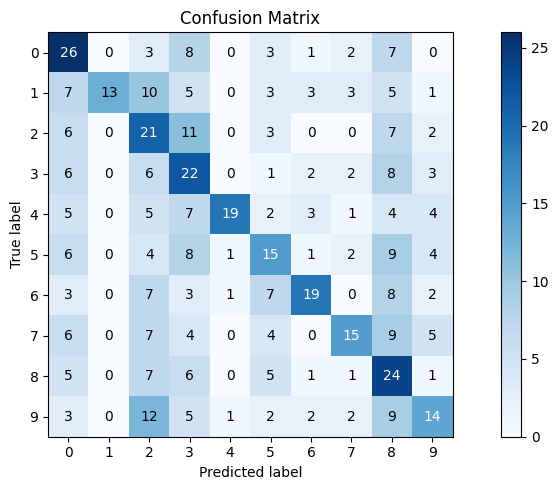

In [14]:
from sklearn.metrics import confusion_matrix as sklearn_confusion_matrix

print_confusion_matrix( sklearn_confusion_matrix(y_true, y_pred) )